In [1]:
import sys
import pandas as pd
import numpy as np

In [2]:
sys.path.append('../../lib')
from agent import Agent
from market import Market
from model.mlp import MLP

c:\users\user\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 14,8

### BTC_USDデータの読み込み

In [5]:
pdf_btcusd = pd.read_csv('../../data/bitmex/BTCUSD/chart_1hour.csv')

In [6]:
pdf_btcusd.head()

,Unnamed: 0,level_0,index,close,high,low,open,s,t,v
0,0,49,2018-07-17 07:00:00,6669.0,6683.0,6654.0,6663.5,ok,1.531778e+09,87418075.0
1,1,48,2018-07-17 06:00:00,6663.5,6667.5,6642.5,6660.0,ok,1.531775e+09,44113455.0
2,2,47,2018-07-17 05:00:00,6660.0,6678.0,6656.0,6675.0,ok,1.531771e+09,49454682.0
3,3,46,2018-07-17 04:00:00,6675.0,6684.0,6633.5,6666.0,ok,1.531768e+09,98226041.0
4,4,45,2018-07-17 03:00:00,6666.0,6697.0,6661.0,6668.0,ok,1.531764e+09,114057471.0


In [7]:
len(pdf_btcusd)

15000

In [8]:
pdf_btcusd['index'] = pd.to_datetime(pdf_btcusd['index'])

In [9]:
# 日時でソート
pdf_btcusd = pdf_btcusd.sort_values('index')
pdf_btcusd = pdf_btcusd.reset_index(drop=True)

In [10]:
pdf_btcusd.head()

,Unnamed: 0,level_0,index,close,high,low,open,s,t,v
0,14999,0,2016-10-30 08:00:00,708.79,715.59,685.66,715.50,ok,1.477782e+09,664883.0
1,14998,1,2016-10-30 09:00:00,703.51,709.69,700.57,708.79,ok,1.477786e+09,1076548.0
2,14997,2,2016-10-30 10:00:00,692.36,704.34,686.50,703.51,ok,1.477789e+09,2160003.0
3,14996,3,2016-10-30 11:00:00,700.65,700.65,692.25,692.36,ok,1.477793e+09,504622.0
4,14995,4,2016-10-30 12:00:00,702.12,703.00,699.71,700.65,ok,1.477796e+09,76242.0


In [11]:
pdf_btcusd['close'][1:30]

1     703.51
2     692.36
3     700.65
4     702.12
5     706.78
6     704.92
7     705.23
8     707.00
9     709.00
10    707.59
11    705.49
12    703.30
13    704.10
14    701.10
15    701.97
16    705.96
17    705.44
18    704.77
19    705.00
20    701.38
21    700.70
22    700.58
23    694.99
24    697.46
25    696.70
26    689.20
27    696.00
28    696.11
29    697.36
Name: close, dtype: float64

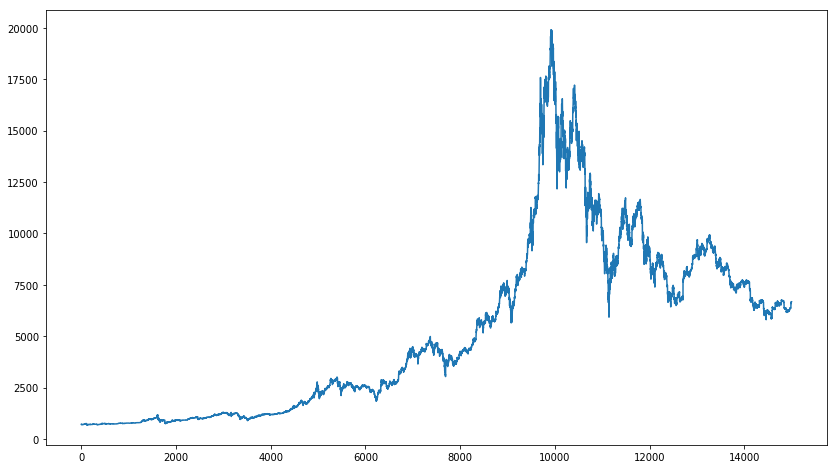

In [12]:
plt.plot(pdf_btcusd['close'])

In [13]:
N_EPISODES = 10
STATE_WINDOW = 30
TIMESERIES_DATA_NUM = 1  # 時系列データの数。今回は終値のみ
N_ACTIONS = 4  # ノーポジ時(仮想通貨保有していない)：ノーポジ継続/買い。非ノーポジ(仮想通貨保有)時：売り、保持
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
DISCOUNT_FACTOR = 0.8
COST = 5.

#### モデルの初期化 (多層パーセプトロン)

In [14]:
model_mlp = MLP(state_shape=(STATE_WINDOW, TIMESERIES_DATA_NUM), n_actions=N_ACTIONS)

init


In [15]:
M = 16
LAYERS = 5
hidden_size = [M]*LAYERS

In [16]:
model_mlp.build_model(n_hidden=hidden_size, learning_rate=LEARNING_RATE, activation='tanh')

In [17]:
model_mlp._model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 68        
Total para

#### エージェント初期化

In [18]:
agent = Agent(model_mlp, discount_factor=DISCOUNT_FACTOR, batch_size=BATCH_SIZE)

#### マーケット初期化

In [19]:
np.array(pdf_btcusd['close']).reshape(pdf_btcusd['close'].shape[0], 1).shape

(15000, 1)

In [20]:
market = Market(
    prices=np.array(pdf_btcusd['close']).reshape(pdf_btcusd['close'].shape[0], 1), 
    window=STATE_WINDOW, 
    model=model_mlp, 
    cost=COST
)

#### 学習

In [21]:
actions_hist = []
cum_rewards_hist = []
assets_hist = []

for episode in range(N_EPISODES):
    
    t_idx = STATE_WINDOW
    
    cum_rewards = []
    prev_cum_rewards = 0.
    actions = []
    states = []
    assets = []
    done = False
    
    state, valid_actions = market.reset()
    print('episode : ', episode)
    #print('state : ', state)
    #print('valid_actions : ', valid_actions)
    
    while not done:
        if t_idx % 1000 == 0:
            print('t_idx : ', t_idx)
        
        # 現在の状態と有効アクションリストから次にとるアクションを取得
        action = agent.act(state, valid_actions)
        #print('action : ', action)
        # アクションを実行し次の状態へ
        next_state, reward, done, valid_actions, asset = market.step(action)
        
        cum_rewards.append(prev_cum_rewards+reward)
        prev_cum_rewards = cum_rewards[-1]
        actions.append(action)
        states.append(next_state)
        assets.append(asset)
        
        # 状態の保存と学習
        agent.remember(state, action, reward, next_state, done, valid_actions)
        agent.replay()
        
        state = next_state
        
        t_idx += 1
        
    actions_hist.append(actions)
    cum_rewards_hist.append(cum_rewards)
    assets_hist.append(assets)

episode :  0
t_idx :  1000
t_idx :  2000
t_idx :  3000
t_idx :  4000
t_idx :  5000
t_idx :  6000
t_idx :  7000
t_idx :  8000
t_idx :  9000
t_idx :  10000
t_idx :  11000
t_idx :  12000
t_idx :  13000
t_idx :  14000
episode :  1
t_idx :  1000
t_idx :  2000
t_idx :  3000
t_idx :  4000
t_idx :  5000
t_idx :  6000
t_idx :  7000
t_idx :  8000
t_idx :  9000
t_idx :  10000
t_idx :  11000
t_idx :  12000
t_idx :  13000
t_idx :  14000
episode :  2
t_idx :  1000
t_idx :  2000
t_idx :  3000
t_idx :  4000
t_idx :  5000
t_idx :  6000
t_idx :  7000
t_idx :  8000
t_idx :  9000
t_idx :  10000
t_idx :  11000
t_idx :  12000
t_idx :  13000
t_idx :  14000
episode :  3
t_idx :  1000
t_idx :  2000
t_idx :  3000
t_idx :  4000
t_idx :  5000
t_idx :  6000
t_idx :  7000
t_idx :  8000
t_idx :  9000
t_idx :  10000
t_idx :  11000
t_idx :  12000
t_idx :  13000
t_idx :  14000
episode :  4
t_idx :  1000
t_idx :  2000
t_idx :  3000
t_idx :  4000
t_idx :  5000
t_idx :  6000
t_idx :  7000
t_idx :  8000
t_idx :  9000
t_idx

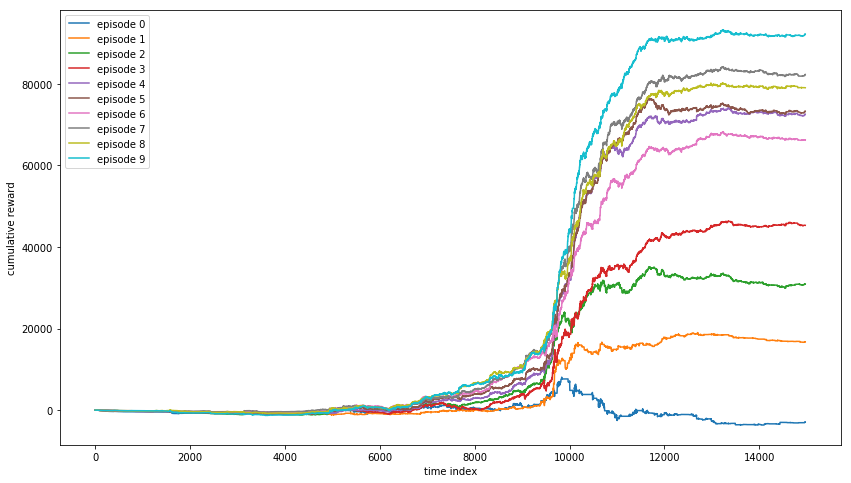

In [22]:
# 総報酬の推移
plt.clf()
for i in range(len(cum_rewards_hist)):
    plt.plot(cum_rewards_hist[i], label='episode {}'.format(i))

plt.xlabel('time index')
plt.ylabel('cumulative reward')
plt.legend()
plt.show()

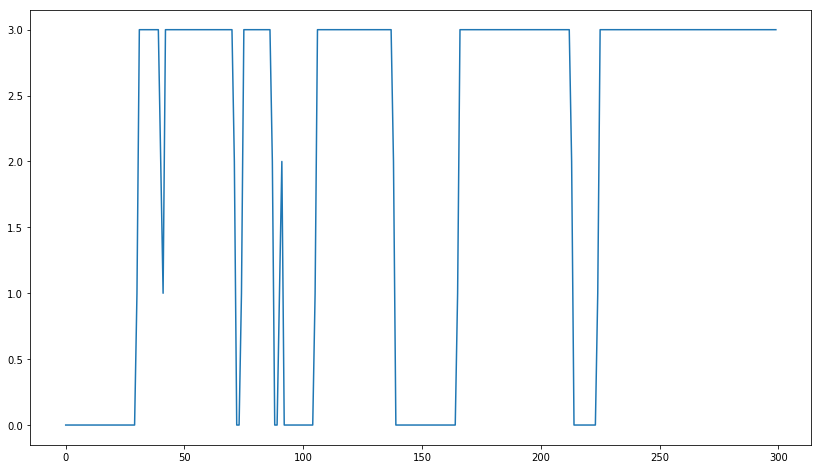

In [23]:
plt.plot(actions_hist[-1][:300])

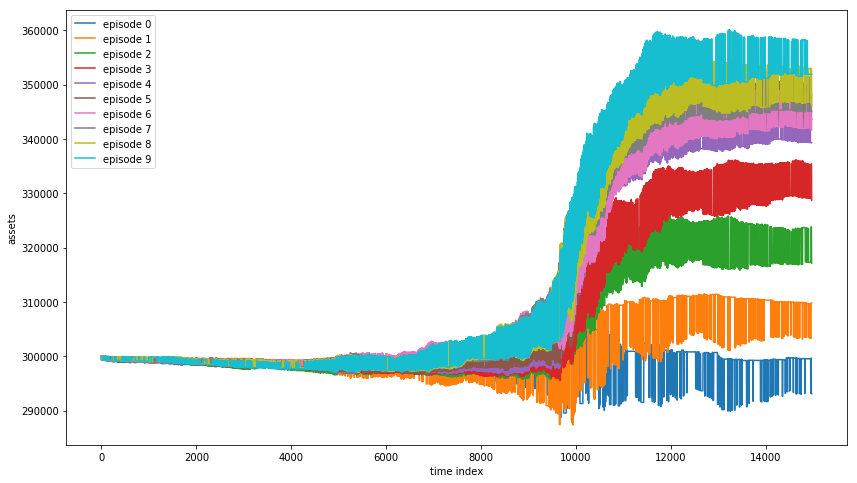

In [24]:
# 総資産の推移
plt.clf()
for i in range(len(assets_hist)):
    plt.plot(assets_hist[i], label='episode {}'.format(i))

plt.xlabel('time index')
plt.ylabel('assets')
plt.legend()
plt.show()

#### モデルの保存

In [25]:
model_mlp.save(fld='../../output/model/bitmex/mlp/cost_5')